In [82]:
import openai
from typing import Literal
from typing_extensions import TypedDict

from langchain_core.tools import tool, BaseTool
from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langsmith import wrappers

from langchain_core.messages import HumanMessage, ToolMessage,AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

from ai_tools import retriever_tool, get_metadata_information_from_arxiv, get_information_from_arxiv, format_and_store


members = ["mongodbagent", "writeragent"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")



class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



mongodb_agent = create_react_agent(
    llm, tools=[get_metadata_information_from_arxiv, get_information_from_arxiv, retriever_tool], 
    state_modifier="You are a helpful research assistant"
)


def mongodbagent_node(state: State) -> Command[Literal["supervisor"]]:
    result = mongodb_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="writeragent")
            ]
        },
        goto="supervisor",
    )



writeragent = create_react_agent(llm, tools=[format_and_store],
                                 state_modifier="You will take any found research or prompt and store it into a txt file")


def writeragent_node(state: State) -> Command[Literal["supervisor"]]:
    result = writeragent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="writeragent")
            ]
        },
        goto="supervisor",
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("mongodbagent", mongodbagent_node)
builder.add_node("writeragent", writeragent_node)
graph = builder.compile()



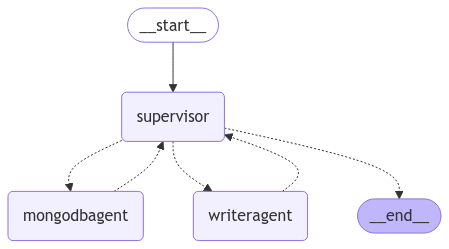

In [83]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))